Your Full Name : Akhilesh Jonnavittula


Your Uplevel Email Address: j.akhilesh@gmail.com


Name of the Problem Statement of Submission : Volcano Eruption Prediction



# Problem1 - Predict Time to Erupt

1) Loading volcanoes Datasets into a dataframe

Lets name the dataframe as df

In [1]:

#1. Read the data files from the datasets
#Currently loading files upon copying to my local filesystem

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
from tsextract.feature_extraction.extract import build_features



#### Reading the volcano dataset from the data files :

#Creating a volcano data object which has the data from each of the volcano data files
class VolcanoData:
    def __init__(self, dir_path, file_name):
        self.dir_path = dir_path
        self.file_name = file_name
        self.volcano_id=-1
        self.observation_num=-1
        self.param_dict={}
        self.time_tilt_dict={}
        self.time_series=[]
        self.tilt_erupt=[]
  
    # The string override giving name path of the file   
    def __str__(self):
        return self.dir_path +'/'+self.file_name
    
    def loadDataFromFile(self,dir_path,file_name):
        self.volcano_id=dir_path.split('/')[-1].replace('Volcano','').strip()
        temp=file_name
        temp=temp.replace('observation','')
        self.observation_num=temp.split('.')[0]
        self.param_dict['volcano_id']=self.volcano_id
        self.param_dict['observation_num']=self.observation_num
        f = open(dir_path+'/'+file_name, "r")
        lines = f.readlines()
        for i in range(0,len(lines)): 
            if len(lines[i].split(','))==2:
                self.param_dict[lines[i].split(',')[0].strip()]=lines[i].split(',')[1].strip()
                if lines[i].split(',')[0].strip() =='tilt_erupt':
                    break
        self.time_series=lines[i+2].strip().split(',')
        self.param_dict['time_to_erupt']=abs(int(self.time_series[0]))
        self.tilt_erupt=lines[i+3].strip().split(',')
        for k in range(len(self.time_series)):
            if self.tilt_erupt[k] is not None:
                self.param_dict[int(self.time_series[k])]=float(self.tilt_erupt[k])
            else:
                self.param_dict[int(self.time_series[k])]=None
            
     
    def populate_param_dict(self):
        self.loadDataFromFile(self.dir_path,self.file_name)
        

        
#returns a list of volcano_data objects
def read_volcano_data(root_dir):
    VolcanoDataList=[]
    for root, dirs, files in os.walk(root_dir,topdown=True):
        if len(files)>1: ### TODO NEED TO FIX THIS BEFORE FINAL 
            for datafile in files:
                volcano_data=VolcanoData(root,datafile)
                volcano_data.populate_param_dict()
                VolcanoDataList.append(volcano_data)               
    return VolcanoDataList

#returns a dataframe from a given list of volcano data object list
def get_dataframe_volcano_data(volcano_data_list):
    consolidate_param_list=[x.param_dict for x in volcano_data_list]
    df = pd.DataFrame.from_dict(consolidate_param_list)
    return df

    
    
#Load the dataset from the file system
path_to_volcano_dir='/Users/akhil/IkML/MiniProject/Volcano_Dataset'
root_dir_of_volcano_dataset=path_to_volcano_dir
volcano_data_list=read_volcano_data(root_dir_of_volcano_dataset)


#create a dataframe from the datasets provided
df = get_dataframe_volcano_data(volcano_data_list)




Print a snapshot of the dataframe obtained after reading the datasets

In [2]:
#This is the base df before any cleaning or modifications are done
df.head()



volcano_id observation_num     v    Patm     g    r         G   rho  \
0          7               4  0.25  100000  9.81  500  10^11.27  2300   
1          7               5  0.25  100000  9.81  500  10^11.27  2300   
2          7               7  0.25  100000  9.81  500  10^11.27  2300   
3          7               6  0.25  100000  9.81  500  10^11.27  2300   
4          7               2  0.25  100000  9.81  500  10^11.27  2300   

        mu  rc  ... -1535 -1534 -1533  -1532  -1531  -1530  -1529  -1528  \
0  10^4.22  26  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
1  10^4.22  26  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2  10^4.22  26  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
3  10^4.22  26  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
4  10^4.22  26  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   

   -1527  -1526  
0    NaN    NaN  
1    NaN    NaN  
2    NaN    NaN  
3    NaN    NaN  
4    NaN    NaN  

[5 rows x 1680 columns]

2)Preliminary Classification 

Figure out the label data :
observed_tilt_erupt -> tilt value before eruption
time_to_erupt -> time taken to erupt

In [3]:
# Review the columns and find the labeled columns
columns_with_non_tilt_vals= ["volcano_id","observation_num", "v","Patm","g","r","G","rho","mu","M","rc","sigma","time_to_erupt"]

#Get the labelled data into  new columns
df['observed_tilt_erupt']=df[0]
df = df.drop([0], axis=1)

##Labeled columns for this dataset are : 
df[['time_to_erupt','observed_tilt_erupt']]

time_to_erupt  observed_tilt_erupt
0             1455         2.623200e-09
1             1472         2.305691e-09
2             1185         2.172094e-09
3             1363         1.674540e-09
4             1130         7.952452e-10
..             ...                  ...
184           1366         4.825675e-08
185           1467         4.808499e-08
186           1456         1.568505e-09
187           1348         9.605925e-10
188           1196         1.408026e-09

[189 rows x 2 columns]

3)Convert the DataFrame columns to have appropriate datatypes

The values of mu,M,G need to be made floats for consumtion into the model

Non Tilt Data is made numeric

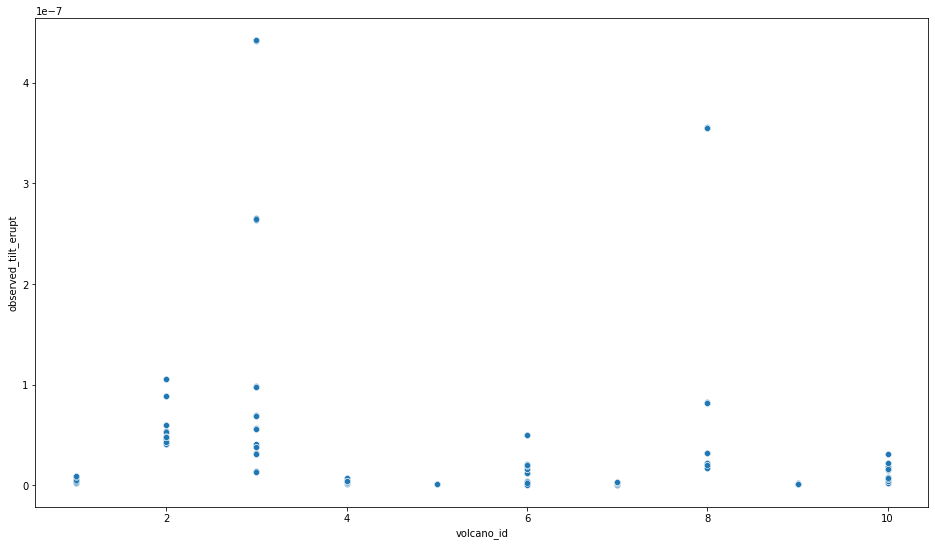

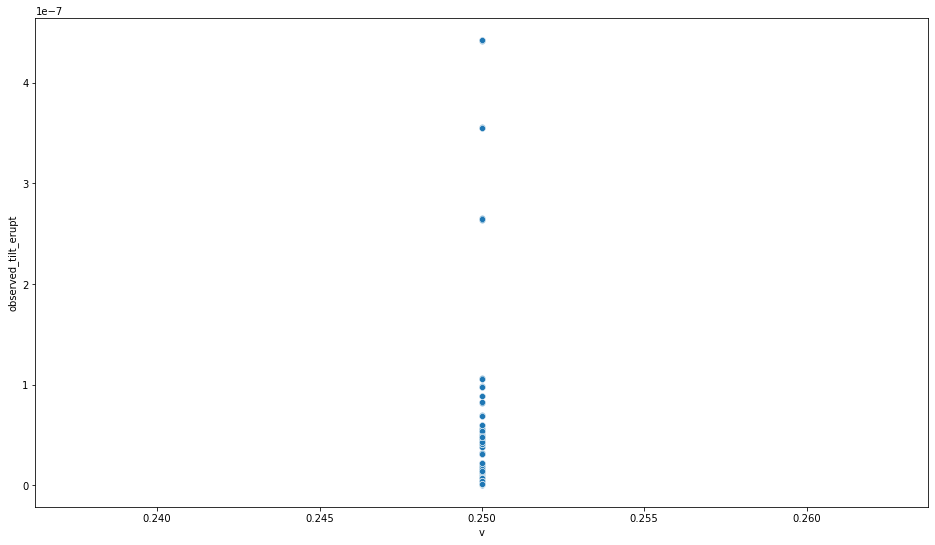

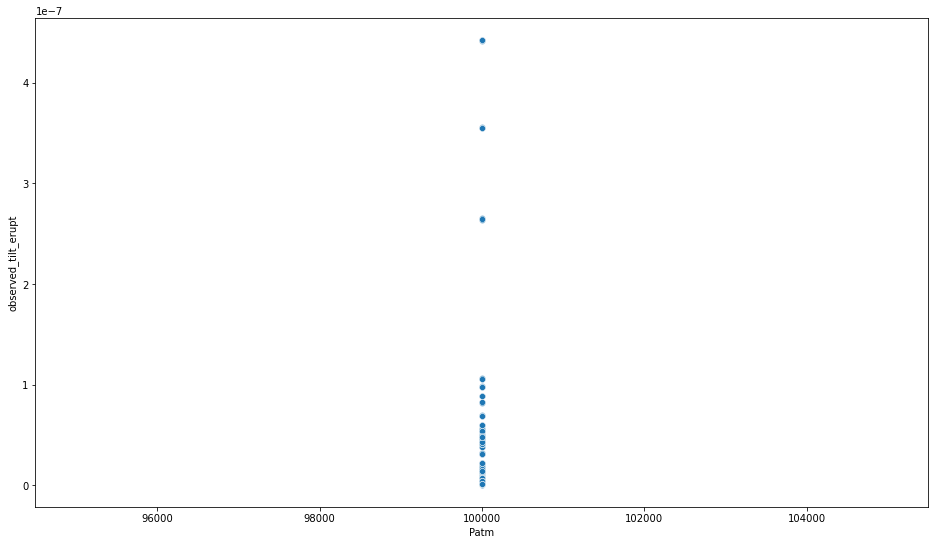

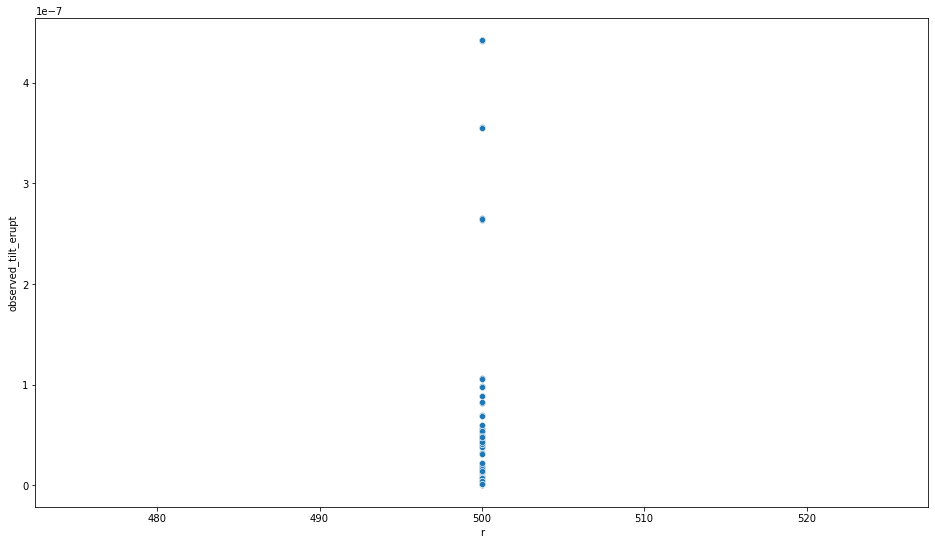

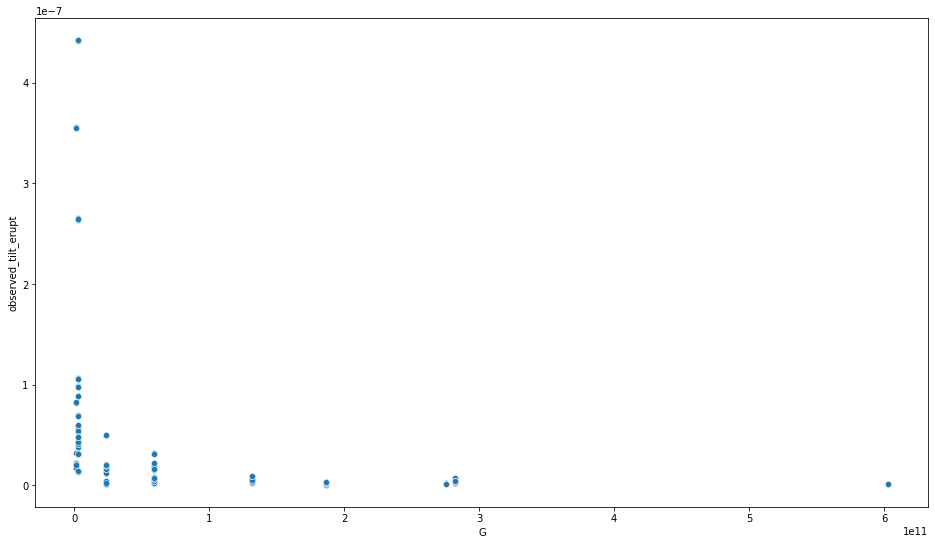

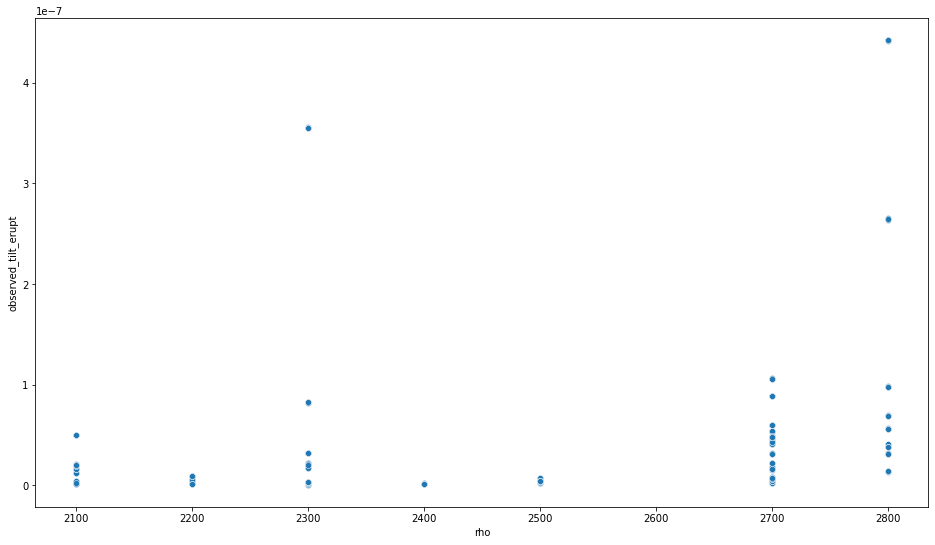

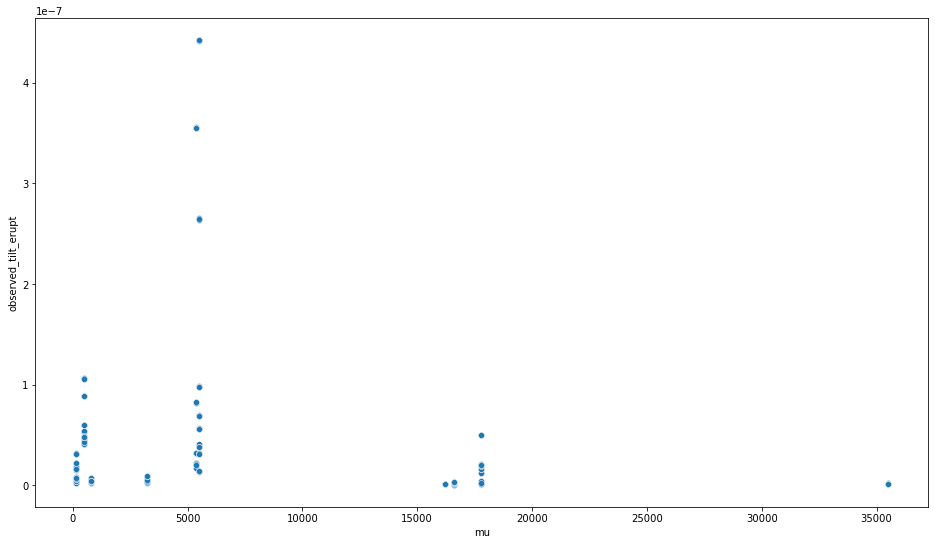

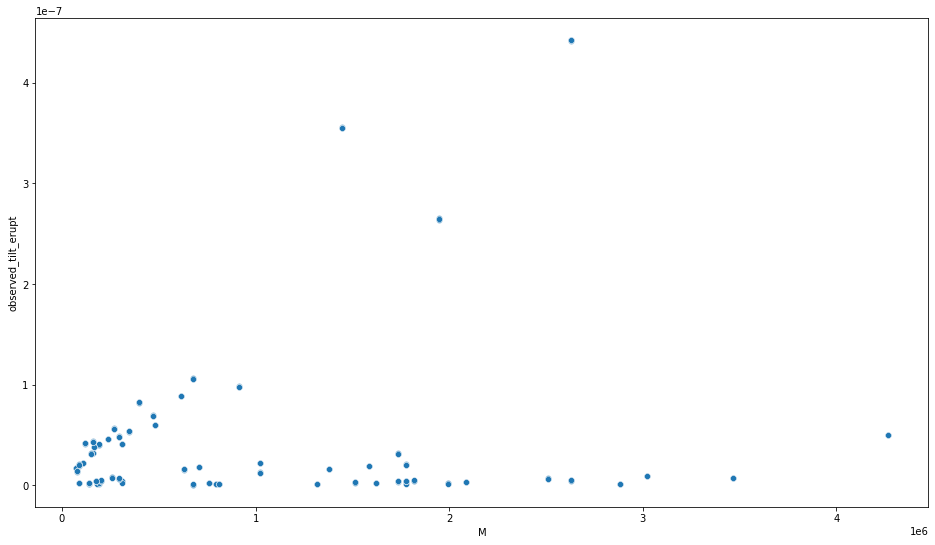

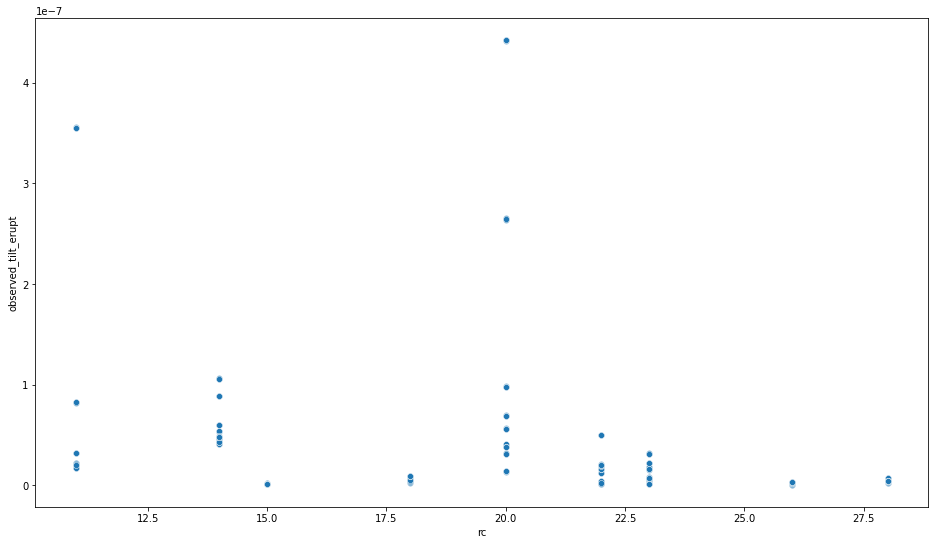

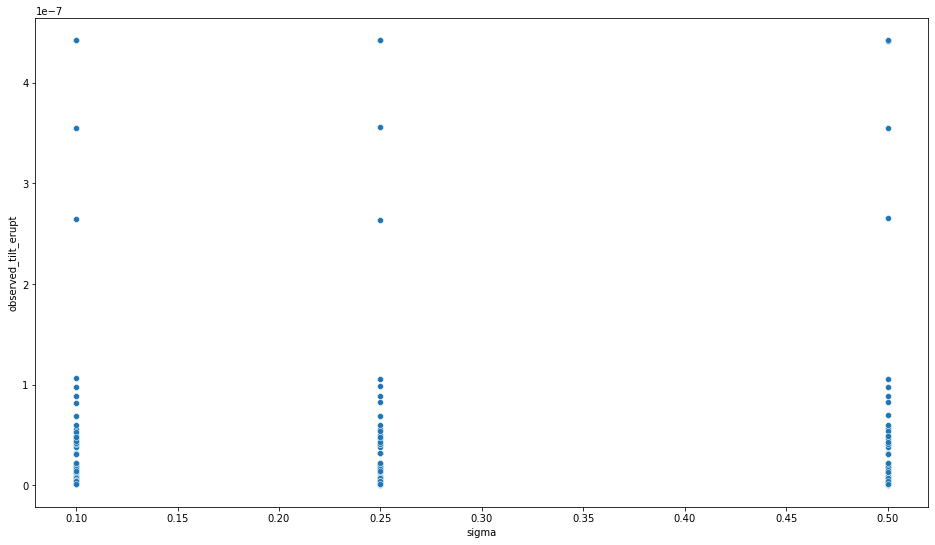

In [4]:

##  Data cleaning ##

# 1. check each column and fix the data types for data manipulation
# use df.dtypes 


#1.1)  M,G and mu columns need to be updated to be floating point numbers
for row in range(0,len(df['M'])):
     #val=df.loc[row,['M']][0] 
     old_M=df.at[row,'M']
     old_G=df.at[row,'G']
     old_mu=df.at[row,'mu']
     new_M=pow(float(old_M.split('^')[0]),float(old_M.split('^')[1]))
     new_G=pow(float(old_G.split('^')[0]),float(old_G.split('^')[1]))
     new_mu=pow(float(old_mu.split('^')[0]),float(old_mu.split('^')[1]))
     df.at[row,'M']=float(new_M)
     df.at[row,'G']=float(new_G)
     df.at[row,'mu']=float(new_mu)
    
#1.2) Fix the rest of the columns to have right data type     
df[columns_with_non_tilt_vals] = df[columns_with_non_tilt_vals].apply(pd.to_numeric)


for feature in ["volcano_id", "v","Patm","r","G","rho","mu","M",'rc',"sigma"]:
    plt.figure(figsize=(16, 9))
    sns.scatterplot(data=df, x=feature,y='observed_tilt_erupt',
                     palette='cool', legend=False)


4.Remove visible redundant columns

Plot for data which remains same for all the volcanoes and drop those columns

In [5]:

#1.3) drop columns that are have same values and are not very useful

df = df.drop(['tilt_erupt','g','v','Patm','r'], axis=1, errors='ignore')
columns_with_non_tilt_vals.remove('g')
columns_with_non_tilt_vals.remove('v')
columns_with_non_tilt_vals.remove('Patm')
columns_with_non_tilt_vals.remove('r')


4.1) 
Compute data about the variable lengths

In [6]:


#Get the volcano data with most number of available tilt values.#
#Find which volcano dataset has the most data and earliest recording#

earliest_df_reading= sorted([col for col in df.columns if col not in columns_with_non_tilt_vals+['observed_tilt_erupt']])[0]
tilt_index_present_in_all_data=-1
for i in range(earliest_df_reading,0):
    if df[i].isna().sum()==0:
        tilt_index_present_in_all_data=i
        break

print('Tilt data sample which all the datasets have -> '+ str(tilt_index_present_in_all_data))
print('Tilt data sample earliest found in all the datasets have ->' + str(earliest_df_reading))

#we can start our tilt_data either at 
#earliest_df_reading= -> which needs data interpolation or at
# tilt_index_present_in_all_data=-1002 which will mean data loss for some of the volcanoes

Tilt data sample which all the datasets have -> -1002
Tilt data sample earliest found in all the datasets have ->-1665


4.2)

Create a sample volcanic tilt vs time plot  to explore how the tilt plot looks

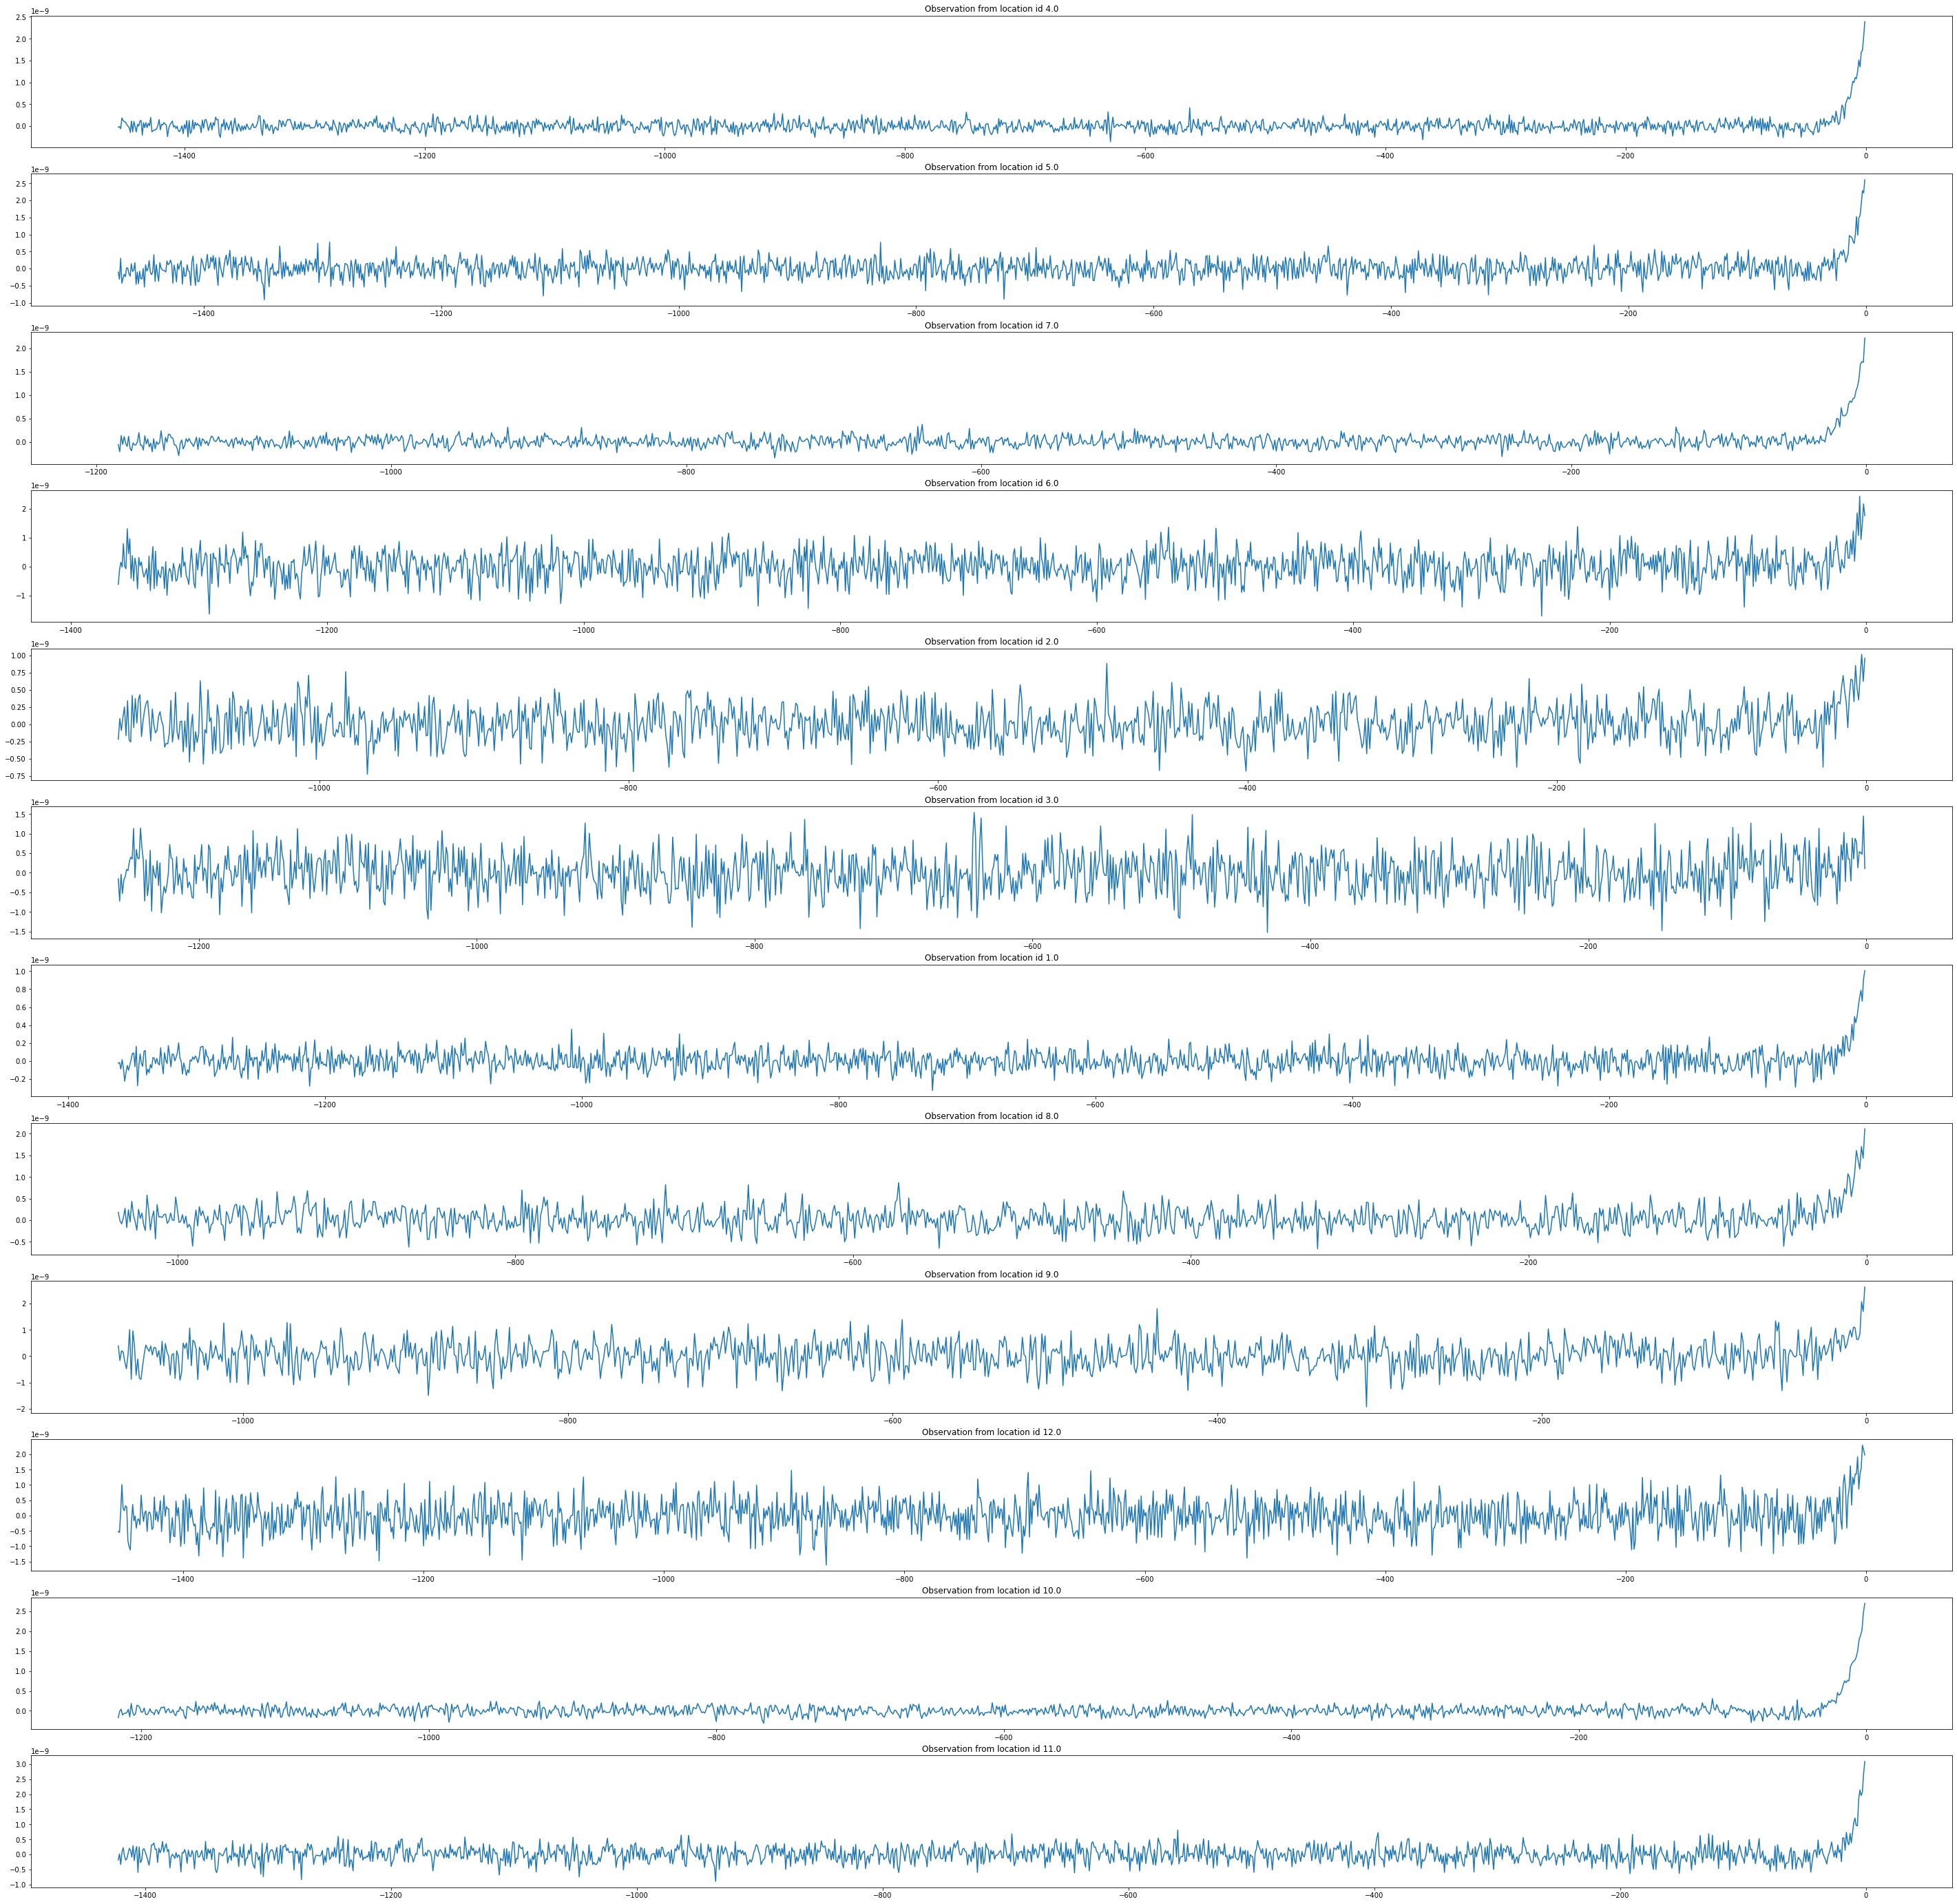

In [7]:

#1.4) 
#Fix the NAN values in each row 
#How do we fix the NAN values in the dataset for different times. we have a varying length
#
#Plot sample volcano plots to identify any patterns
#Using Volcano 7


df_volcano7=df.where(df['volcano_id']==7)
earliest_df_volcano7_reading= sorted([col for col in df_volcano7.columns if col not in columns_with_non_tilt_vals +['observed_tilt_erupt']])[0]
df_7_cols=[col for col in df_volcano7.columns] 
x1=[i for i in range(earliest_df_volcano7_reading,0,1)]
df['volcano_id'].values == 7
#mask = df['volcano_id'].values == '7'
#mask.shape
x1=[i for i in range(earliest_df_volcano7_reading,0,1)]
mask = df['volcano_id'].values == 7
df_new = df[mask]

fig, ax = plt.subplots(nrows=df_new.shape[0], ncols=1,figsize=(50, 50))


for row in range(0,df_new.shape[0]):
     y=[df.iloc[row][i] for i in range(earliest_df_volcano7_reading,0,1)]
     ax[row].plot(x1,y)
     ax[row].set(title='Observation from location id '+ str(df.iloc[row]['observation_num']))


Observations from previous plot reveal the below :



1) Tilt plot ramps up between 100 time units to time of errupt

2) Tilt plot stays consistent between 1000 to 400 time units before eruption

3) Scale of the tilt values need to be fixed 

4) With volcano data having verying lengths, we need to fix the NAN values - either by dropping or by interpolating


Moving on............................

5)

Lets fix the NAN values by interpolation

next step does these

1) The tilt data is in Radians -> Convert it to Nano Radians

2) interpolate missing data 

In [8]:


#Interpolate NAN values 
# Create a dataframe which will have the tilt values . Lets call it 'interpolated_df'
#1) Convert all the tilt Data to nanoRadians
#2) Interpolate missing NAN values at the tail of the volcano dataset to have a mean value between (T-1200) to (T-1000)
#3 This interpolation would mean no loss of tilt data when trainign is performed

#This cell has tilt data before NAN is interpolated
#Create a new dataframe and copying over tilt value data
#interpolated_df=df.copy()
tilt_data_columns=[i for i in range(earliest_df_reading,0)]
tilt_data_columns.append('observed_tilt_erupt')

interpolated_df=df[tilt_data_columns]
#tilt_data_columns=[col for col in interpolated_df.columns if col not in columns_with_non_tilt_vals]

#interpolated_df=interpolated_df[tilt_data_columns] 
def convert_to_nanoRadians(value):
    if value is None:
        return
    value=str(value)
    vals=value.split('e')
    
    vals[0]=float(vals[0])
    vals[1]=int(vals[1])
    if vals[1] == -9:
        return vals[0]
    delta=vals[1]+9
    return vals[0]*pow(10,delta)
# use the applymap method to update all cells
interpolated_df = interpolated_df.applymap(convert_to_nanoRadians,na_action='ignore')
# Looking at previous eruption graph,safe to get the mean of sample from t= -1200 to -1000 
#to interpolate previous unavailable data for each volcano
mean_interpolated_df=interpolated_df[[col for col in range(-1200,-1000,1)]]
interpolated_mean_values_to_populate=mean_interpolated_df.mean(axis=1)
for p in range(0,189):
    interpolated_df.iloc[p].fillna(interpolated_mean_values_to_populate[p],inplace=True)

#5.1
interpolated_dfnow had observed_tilt_erupt

5.1
Verify NANs are removed in the time series data


In [9]:

#Verify no NAN values exist in the dataframe
interpolated_df.isnull().sum()
interpolated_df.head()



-1665     -1664     -1663     -1662     -1661     -1660     -1659  \
0  0.002590  0.002590  0.002590  0.002590  0.002590  0.002590  0.002590   
1  0.023311  0.023311  0.023311  0.023311  0.023311  0.023311  0.023311   
2 -0.003348 -0.003348 -0.003348 -0.003348 -0.003348 -0.003348 -0.003348   
3 -0.002120 -0.002120 -0.002120 -0.002120 -0.002120 -0.002120 -0.002120   
4  0.010517  0.010517  0.010517  0.010517  0.010517  0.010517  0.010517   

      -1658     -1657     -1656  ...        -9        -8        -7        -6  \
0  0.002590  0.002590  0.002590  ...  1.111918  1.084709  1.251256  1.507699   
1  0.023311  0.023311  0.023311  ...  0.996234  1.524013  0.980791  1.492695   
2 -0.003348 -0.003348 -0.003348  ...  0.923402  0.942629  1.088757  1.178626   
3 -0.002120 -0.002120 -0.002120  ...  0.193487  0.999597  1.862110  1.080438   
4  0.010517  0.010517  0.010517  ...  0.638520  0.326571  0.850146  0.518243   

         -5        -4        -3        -2        -1  observed_tilt_erupt  
0  1.355177  1.688673  1.731482  2.030745  2.389152             2.623200  
1  1.554293  1.891921  2.283830  2.219468  2.601872             2.305691  
2  1.339383  1.657456  1.714408  1.699079  2.219522             2.172094  
3  2.440893  0.939483  1.459774  2.172465  1.765184             1.674540  
4  0.350891  0.703433  1.012724  0.621565  0.954929             0.795245  

[5 rows x 1666 columns]

In [10]:
#interpolated_df[0]=interpolated_df['observed_tilt_erupt']
#interpolated_df.drop('observed_tilt_erupt',axis=1)
#tilt_data_columns.remove('observed_tilt_erupt')
##drop redundant columns


In [11]:
##find the time series data which occurs between the earliest sample and the earliest sample present in all volcano data 
redundant_data=[col for col in range(earliest_df_reading,tilt_index_present_in_all_data,1)]





6)

Now combine the  interpolated_df which has the interpolated time series data with rest of the non tilt feature data

update the interpolated_df dataframe which currently has tilt values with rest of the non tilt data


In [12]:
non_tilt_data_col=df[columns_with_non_tilt_vals]
#non_tilt_data_col.drop('observed_tilt_erupt',axis=1) # we already have a observed_tilt_erupt
interpolated_df=non_tilt_data_col.merge(interpolated_df,left_index=True, right_index=True)


interpolated_df will now have the feature set that includes all tilt data along with other feature set of use

In [13]:
interpolated_df.columns

Index([         'volcano_id',     'observation_num',                   'G',
                       'rho',                  'mu',                   'M',
                        'rc',               'sigma',       'time_to_erupt',
                       -1665,
       ...
                          -9,                    -8,                    -7,
                          -6,                    -5,                    -4,
                          -3,                    -2,                    -1,
       'observed_tilt_erupt'],
      dtype='object', length=1675)

In [14]:
#interpolated_df.drop('observed_tilt_erupt_x',axis=1)
#interpolated_df['observed_tilt_erupt']=interpolated_df['observed_tilt_erupt_y']
#interpolated_df.drop('observed_tilt_erupt_y',axis=1)



7)

Next.... we need to perform scaling ................................

In [15]:
#7.1) Find columns that should not  be scaled

interpolated_df.columns
col_not_to_scale=['volcano_id','observation_num','time_to_erupt','observed_tilt_erupt']

Columns that will be scaled........

In [16]:
scaled_string_cols=["G","rho","mu","M","rc","sigma"]
scaled_string_cols

['G', 'rho', 'mu', 'M', 'rc', 'sigma']

In [17]:
tilt_data_columns

[-1665,
 -1664,
 -1663,
 -1662,
 -1661,
 -1660,
 -1659,
 -1658,
 -1657,
 -1656,
 -1655,
 -1654,
 -1653,
 -1652,
 -1651,
 -1650,
 -1649,
 -1648,
 -1647,
 -1646,
 -1645,
 -1644,
 -1643,
 -1642,
 -1641,
 -1640,
 -1639,
 -1638,
 -1637,
 -1636,
 -1635,
 -1634,
 -1633,
 -1632,
 -1631,
 -1630,
 -1629,
 -1628,
 -1627,
 -1626,
 -1625,
 -1624,
 -1623,
 -1622,
 -1621,
 -1620,
 -1619,
 -1618,
 -1617,
 -1616,
 -1615,
 -1614,
 -1613,
 -1612,
 -1611,
 -1610,
 -1609,
 -1608,
 -1607,
 -1606,
 -1605,
 -1604,
 -1603,
 -1602,
 -1601,
 -1600,
 -1599,
 -1598,
 -1597,
 -1596,
 -1595,
 -1594,
 -1593,
 -1592,
 -1591,
 -1590,
 -1589,
 -1588,
 -1587,
 -1586,
 -1585,
 -1584,
 -1583,
 -1582,
 -1581,
 -1580,
 -1579,
 -1578,
 -1577,
 -1576,
 -1575,
 -1574,
 -1573,
 -1572,
 -1571,
 -1570,
 -1569,
 -1568,
 -1567,
 -1566,
 -1565,
 -1564,
 -1563,
 -1562,
 -1561,
 -1560,
 -1559,
 -1558,
 -1557,
 -1556,
 -1555,
 -1554,
 -1553,
 -1552,
 -1551,
 -1550,
 -1549,
 -1548,
 -1547,
 -1546,
 -1545,
 -1544,
 -1543,
 -1542,
 -1541,


a)

For modeling the time to eruption --- > output label is the time to erupt


b)

For modeling magnitude of eruption --- > output label is the observed_tilt



8) Autoscaling

In [18]:

#Auto scaling of non tilt values

#interpolated_df=interpolated_df.T
#interpolated_df

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

scaler = MinMaxScaler()
#scaler = RobustScaler()

#use tilt_data_columns if label is scaled
#remove observed_tilt_erupt from tilt_data_columns if output is not scaled
#tilt_data_columns.remove('observed_tilt_erupt')
cols_to_scale=scaled_string_cols+tilt_data_columns
#interpolated_df[[col for col in scaled_string_cols]] = scaler.fit_transform(interpolated_df[[col for col in scaled_string_cols]])
#interpolated_df[[col for col in tilt_data_columns ]] = scaler.fit_transform(interpolated_df[[col for col in tilt_data_columns]])
interpolated_df[[col for col in cols_to_scale ]] = scaler.fit_transform(interpolated_df[[col for col in cols_to_scale]])


interpolated_df.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


volcano_id  observation_num         G       rho        mu         M  \
0           7                4  0.307406  0.285714  0.465507  0.406795   
1           7                5  0.307406  0.285714  0.465507  0.406795   
2           7                7  0.307406  0.285714  0.465507  0.369482   
3           7                6  0.307406  0.285714  0.465507  0.406795   
4           7                2  0.307406  0.285714  0.465507  0.143952   

         rc  sigma  time_to_erupt     -1665  ...        -9        -8  \
0  0.882353  0.000           1455  0.210769  ...  0.028203  0.016618   
1  0.882353  0.375           1472  0.227881  ...  0.027659  0.018584   
2  0.882353  0.000           1185  0.205866  ...  0.027316  0.015983   
3  0.882353  1.000           1363  0.206880  ...  0.023879  0.016237   
4  0.882353  0.375           1130  0.217316  ...  0.025974  0.013226   

         -7        -6        -5        -4        -3        -2        -1  \
0  0.010421  0.008073  0.005446  0.006823  0.006426  0.006877  0.005780   
1  0.009276  0.008013  0.006197  0.007544  0.008197  0.007415  0.006320   
2  0.009733  0.006755  0.005387  0.006712  0.006371  0.005931  0.005350   
3  0.013006  0.006362  0.009542  0.004163  0.005555  0.007281  0.004198   
4  0.008723  0.004111  0.001658  0.003326  0.004121  0.002859  0.002142   

   observed_tilt_erupt  
0             0.004269  
1             0.003550  
2             0.003248  
3             0.002122  
4             0.000132  

[5 rows x 1675 columns]

Plot the tilt graph after autoscaling

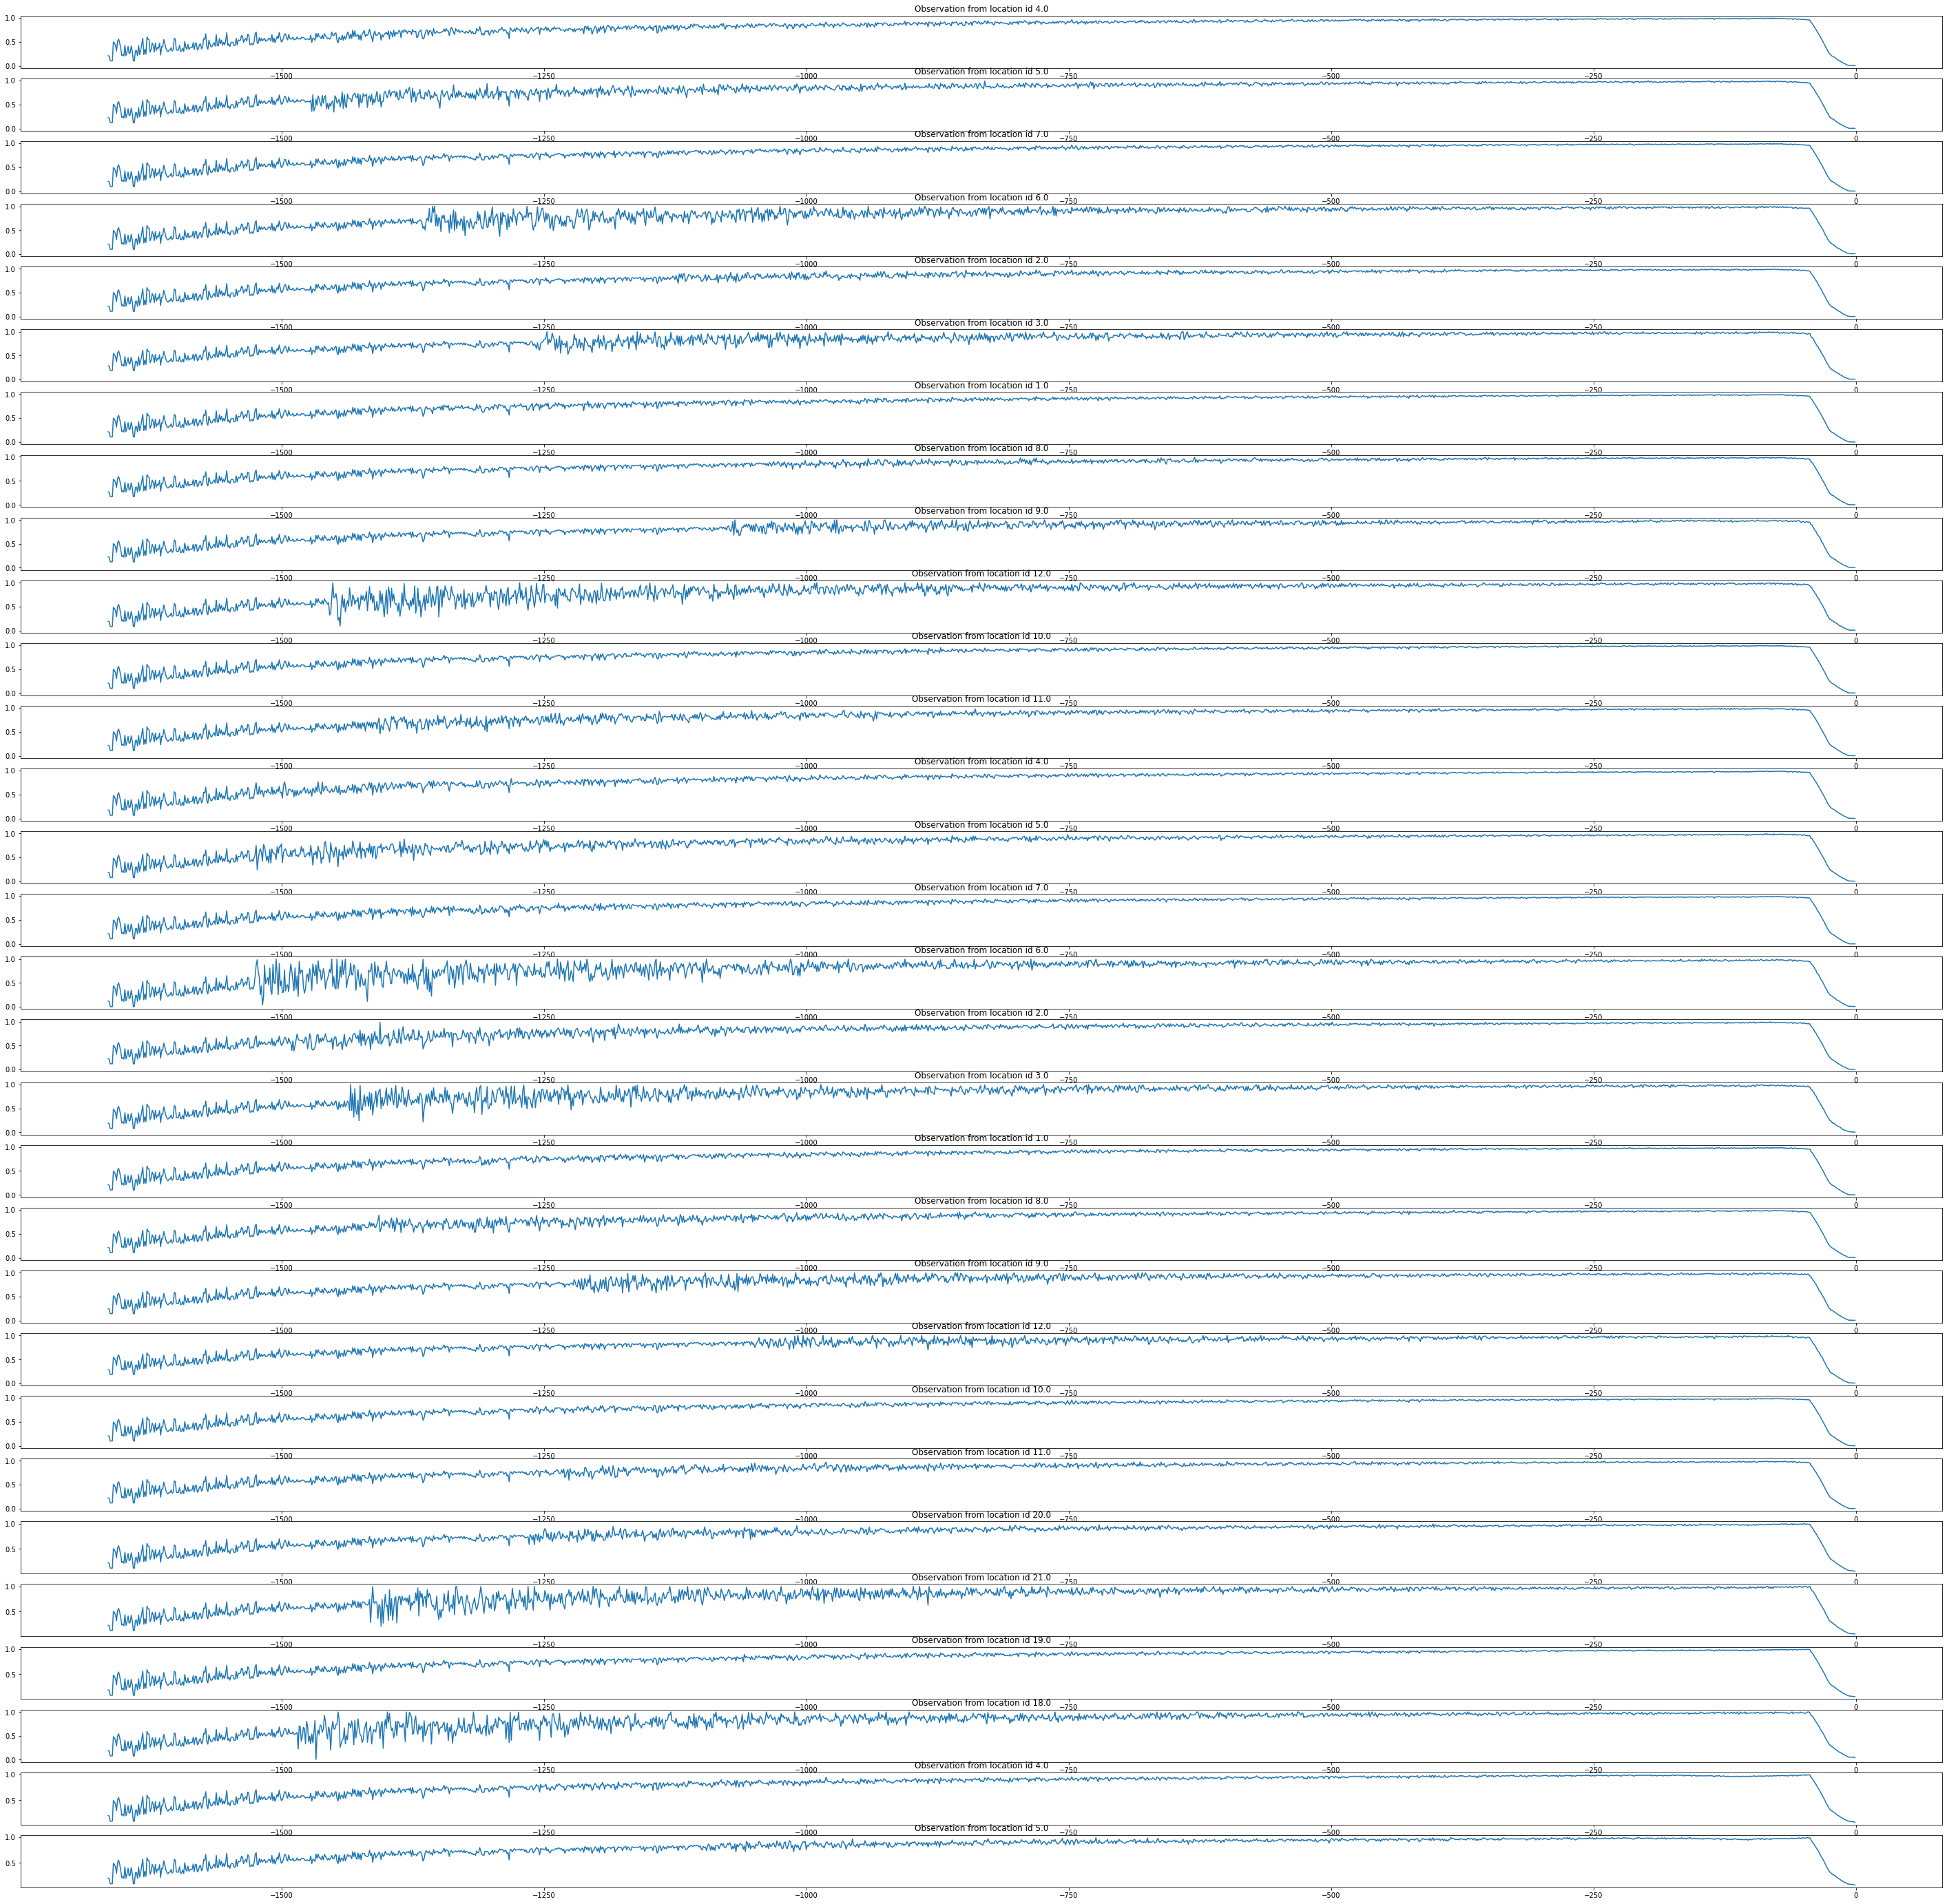

In [19]:

df_volcano3=df.where(interpolated_df['volcano_id']==3)
earliest_df_volcano3_reading= sorted([col for col in df_volcano3.columns if col not in columns_with_non_tilt_vals+['observed_tilt_erupt'] ])[0]
df_3_cols=[col for col in df_volcano3.columns] 
x1=[i for i in range(earliest_df_volcano3_reading,0,1)]
df['volcano_id'].values == 3

x1=[i for i in range(earliest_df_volcano3_reading,0,1)]
mask = df['volcano_id'].values == 3
df_new = df[mask]

fig, ax = plt.subplots(nrows=df_new.shape[0], ncols=1,figsize=(50, 50))


for row in range(0,df_new.shape[0]):
     y=[interpolated_df.iloc[row][i] for i in range(earliest_df_volcano3_reading,0,1)]
     ax[row].plot(x1,y)
     ax[row].set(title='Observation from location id '+ str(df.iloc[row]['observation_num']))

In [20]:
interpolated_df[['time_to_erupt','observed_tilt_erupt']]



time_to_erupt  observed_tilt_erupt
0             1455             0.004269
1             1472             0.003550
2             1185             0.003248
3             1363             0.002122
4             1130             0.000132
..             ...                  ...
184           1366             0.107529
185           1467             0.107141
186           1456             0.001882
187           1348             0.000506
188           1196             0.001519

[189 rows x 2 columns]

The observed_tilt_erupt is also autoscaled .. but it is going to be used as a feature in the next few steps.. 

no worries...(hopefully)

In [21]:
interpolated_df.columns

Index([         'volcano_id',     'observation_num',                   'G',
                       'rho',                  'mu',                   'M',
                        'rc',               'sigma',       'time_to_erupt',
                       -1665,
       ...
                          -9,                    -8,                    -7,
                          -6,                    -5,                    -4,
                          -3,                    -2,                    -1,
       'observed_tilt_erupt'],
      dtype='object', length=1675)

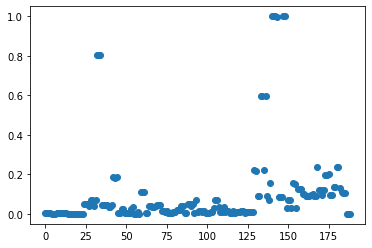

In [22]:
# Scatter plot of the observed_tilt_erupt after autoscaling

plt.scatter([i for i in range(interpolated_df.shape[0])], interpolated_df['observed_tilt_erupt'])
plt.show()


## Analyzing  Outliers

In [23]:

outlier_interpolated_df=interpolated_df[interpolated_df['observed_tilt_erupt']>0.4]
outlier_rows_to_drop=outlier_interpolated_df.index.values
print('These rows are outliers :' +str(outlier_rows_to_drop))

These rows are outliers :[ 32  33  34 133 134 136 140 141 142 143 147 148]


In [24]:
interpolated_df.head()

volcano_id  observation_num         G       rho        mu         M  \
0           7                4  0.307406  0.285714  0.465507  0.406795   
1           7                5  0.307406  0.285714  0.465507  0.406795   
2           7                7  0.307406  0.285714  0.465507  0.369482   
3           7                6  0.307406  0.285714  0.465507  0.406795   
4           7                2  0.307406  0.285714  0.465507  0.143952   

         rc  sigma  time_to_erupt     -1665  ...        -9        -8  \
0  0.882353  0.000           1455  0.210769  ...  0.028203  0.016618   
1  0.882353  0.375           1472  0.227881  ...  0.027659  0.018584   
2  0.882353  0.000           1185  0.205866  ...  0.027316  0.015983   
3  0.882353  1.000           1363  0.206880  ...  0.023879  0.016237   
4  0.882353  0.375           1130  0.217316  ...  0.025974  0.013226   

         -7        -6        -5        -4        -3        -2        -1  \
0  0.010421  0.008073  0.005446  0.006823  0.006426  0.006877  0.005780   
1  0.009276  0.008013  0.006197  0.007544  0.008197  0.007415  0.006320   
2  0.009733  0.006755  0.005387  0.006712  0.006371  0.005931  0.005350   
3  0.013006  0.006362  0.009542  0.004163  0.005555  0.007281  0.004198   
4  0.008723  0.004111  0.001658  0.003326  0.004121  0.002859  0.002142   

   observed_tilt_erupt  
0             0.004269  
1             0.003550  
2             0.003248  
3             0.002122  
4             0.000132  

[5 rows x 1675 columns]

In [25]:
#Apply a sliding slope for EDA 


slope_df=interpolated_df.copy()
slope_df.drop(non_tilt_data_col,axis=1,errors='ignore',inplace=True)
slope_df.drop(['observed_tilt_erupt'],axis=1,errors='ignore',inplace=True)
sliding_slope_columns=['sliding_slope_'+ str(i) for i in range(earliest_df_reading,0)]

#Apply sliding windows
# Define the size of the sliding window
window_size = 50

# Define Custom Function to Calculate Slope
def calculate_slope(data):
    x = range(len(data))
    y = data.values
    slope, _, _, _, _ = stats.linregress(x, y)
    return slope
# Apply Custom Function to Rolling Window
rolling_slope_df = slope_df.rolling(window_size,axis=1).apply(calculate_slope)
rolling_slope_df.columns=sliding_slope_columns

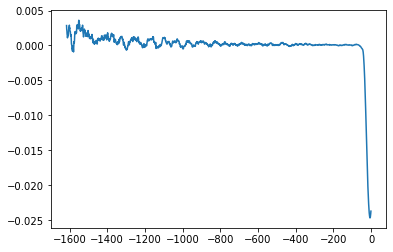

In [26]:
 
yslope=[rolling_slope_df.iloc[0][i] for i in range(earliest_df_reading,0,1)]
plt.plot(x1,yslope)


Create clean_df  dataframe from interpolated_df 

This will be used by tsextract for feature extraction



In [27]:
clean_df=interpolated_df.copy()
clean_df.drop(non_tilt_data_col,axis=1,errors='ignore',inplace=True)
clean_df.drop(['observed_tilt_erupt_x'],axis=1,errors='ignore',inplace=True)
clean_df[0]=clean_df['observed_tilt_erupt']
clean_df.drop(['observed_tilt_erupt'],axis=1,errors='ignore',inplace=True)


redundant_data=[col for col in range(earliest_df_reading,tilt_index_present_in_all_data,1)]
clean_df=clean_df.drop(redundant_data,axis=1)

clean_df= clean_df.transpose()
clean_df.index = clean_df.index.astype(int)
clean_df = clean_df.sort_index()
#clean_df only has autoscaled tilt_values
clean_df.tail()



0         1         2         3         4         5         6    \
-4  0.006823  0.007544  0.006712  0.004163  0.003326  0.002672  0.003620   
-3  0.006426  0.008197  0.006371  0.005555  0.004121  0.002390  0.003010   
-2  0.006877  0.007415  0.005931  0.007281  0.002859  0.005223  0.003694   
-1  0.005780  0.006320  0.005350  0.004198  0.002142  0.000000  0.002269   
 0  0.004269  0.003550  0.003248  0.002122  0.000132  0.000000  0.000891   

         7         8         9    ...       179       180       181       182  \
-4  0.005027  0.003840  0.006339  ...  0.053492  0.137822  0.138547  0.052762   
-3  0.006341  0.007499  0.008238  ...  0.070415  0.164032  0.163118  0.071271   
-2  0.005173  0.005930  0.007172  ...  0.090327  0.187930  0.189173  0.090462   
-1  0.005078  0.006379  0.004735  ...  0.109393  0.211931  0.211694  0.110354   
 0  0.003155  0.003357  0.004978  ...  0.133848  0.238559  0.238189  0.133428   

         183       184       185       186       187       188  
-4  0.053552  0.052969  0.052777  0.002892  0.003665  0.004084  
-3  0.062865  0.064055  0.063951  0.004323  0.005704  0.003763  
-2  0.076610  0.075201  0.075333  0.003863  0.006821  0.004088  
-1  0.087357  0.089042  0.089395  0.002845  0.005624  0.001988  
 0  0.108399  0.107529  0.107141  0.001882  0.000506  0.001519  

[5 rows x 189 columns]

In [28]:
from tsextract.domain.statistics import median, mean, skew, kurtosis

slide_window_size=50
total_num_datasets=df.shape[0]
target_lag=1
features_request = {
    "window":[slide_window_size],
    "window_statistic": [slide_window_size, mean]
}
master_df_list=[]
for i in range(0,total_num_datasets):
    features = build_features(clean_df[i], features_request, include_tzero=True, target_lag=1)
    features['time_to_erupt']=[abs(k)+1+target_lag for  k in clean_df.index.values][:features.shape[0]]
    features[['volcano_id','observation_num','G','rho','mu','M','rc','sigma']]=interpolated_df[['volcano_id','observation_num','G','rho','mu','M','rc','sigma']].iloc[i]
    master_df_list.append(features)

master_df=pd.concat(master_df_list)
master_df['tilt_at_erupt']=master_df['Target_Tplus1']
master_df.shape 


(179928, 63)

Feature extraction :  Create a slope across interval as another feature


In [29]:
master_df['slope_across_window_length']=(master_df[master_df.columns[0]]-master_df['tzero'])/slide_window_size

In [30]:
master_df.drop('Target_Tplus1',axis=1)

T-50      T-49      T-48      T-47      T-46      T-45      T-44  \
Date                                                                         
-952  0.820039  0.815842  0.779913  0.852170  0.829202  0.846051  0.833983   
-951  0.815842  0.779913  0.852170  0.829202  0.846051  0.833983  0.879629   
-950  0.779913  0.852170  0.829202  0.846051  0.833983  0.879629  0.877654   
-949  0.852170  0.829202  0.846051  0.833983  0.879629  0.877654  0.843272   
-948  0.829202  0.846051  0.833983  0.879629  0.877654  0.843272  0.844689   
...        ...       ...       ...       ...       ...       ...       ...   
-5    0.970256  0.965471  0.963507  0.963383  0.962394  0.959727  0.964752   
-4    0.965471  0.963507  0.963383  0.962394  0.959727  0.964752  0.951948   
-3    0.963507  0.963383  0.962394  0.959727  0.964752  0.951948  0.960988   
-2    0.963383  0.962394  0.959727  0.964752  0.951948  0.960988  0.954075   
-1    0.962394  0.959727  0.964752  0.951948  0.960988  0.954075  0.951371   

          T-43      T-42      T-41  ...  volcano_id  observation_num  \
Date                                ...                                
-952  0.879629  0.877654  0.843272  ...         7.0              4.0   
-951  0.877654  0.843272  0.844689  ...         7.0              4.0   
-950  0.843272  0.844689  0.825108  ...         7.0              4.0   
-949  0.844689  0.825108  0.846871  ...         7.0              4.0   
-948  0.825108  0.846871  0.840793  ...         7.0              4.0   
...        ...       ...       ...  ...         ...              ...   
-5    0.951948  0.960988  0.954075  ...         5.0              1.0   
-4    0.960988  0.954075  0.951371  ...         5.0              1.0   
-3    0.954075  0.951371  0.949011  ...         5.0              1.0   
-2    0.951371  0.949011  0.904338  ...         5.0              1.0   
-1    0.949011  0.904338  0.879554  ...         5.0              1.0   

             G       rho        mu         M        rc  sigma  tilt_at_erupt  \
Date                                                                           
-952  0.307406  0.285714  0.465507  0.406795  0.882353    0.0       0.855416   
-951  0.307406  0.285714  0.465507  0.406795  0.882353    0.0       0.830833   
-950  0.307406  0.285714  0.465507  0.406795  0.882353    0.0       0.808754   
-949  0.307406  0.285714  0.465507  0.406795  0.882353    0.0       0.880351   
-948  0.307406  0.285714  0.465507  0.406795  0.882353    0.0       0.849651   
...        ...       ...       ...       ...       ...    ...            ...   
-5    1.000000  0.142857  0.454815  0.670487  0.705882    0.0       0.004084   
-4    1.000000  0.142857  0.454815  0.670487  0.705882    0.0       0.003763   
-3    1.000000  0.142857  0.454815  0.670487  0.705882    0.0       0.004088   
-2    1.000000  0.142857  0.454815  0.670487  0.705882    0.0       0.001988   
-1    1.000000  0.142857  0.454815  0.670487  0.705882    0.0       0.001519   

      slope_across_window_length  
Date                              
-952                   -0.000045  
-951                   -0.000791  
-950                   -0.001018  
-949                    0.000868  
-948                   -0.001023  
...                          ...  
-5                      0.019340  
-4                      0.019228  
-3                      0.019195  
-2                      0.019186  
-1                      0.019208  

[179928 rows x 63 columns]

## TEST TRAIN SPLIT

Using GroupShuffleSplit so as to not pollute train and test volcano data

In [31]:
import random
from sklearn.model_selection import GroupShuffleSplit
splitter=GroupShuffleSplit(test_size=.20,n_splits=2,random_state=7)
split=splitter.split(master_df,groups=master_df['volcano_id'])
train_inds,test_inds=next(split)
train_df=master_df.iloc[train_inds]
test_df=master_df.iloc[test_inds]




In [32]:
print(train_df['volcano_id'].unique())
print(test_df['volcano_id'].unique())
train_df.columns

[ 7.  8.  1. 10.  4.  3.  2.  5.]
[9. 6.]


Index(['T-50', 'T-49', 'T-48', 'T-47', 'T-46', 'T-45', 'T-44', 'T-43', 'T-42',
       'T-41', 'T-40', 'T-39', 'T-38', 'T-37', 'T-36', 'T-35', 'T-34', 'T-33',
       'T-32', 'T-31', 'T-30', 'T-29', 'T-28', 'T-27', 'T-26', 'T-25', 'T-24',
       'T-23', 'T-22', 'T-21', 'T-20', 'T-19', 'T-18', 'T-17', 'T-16', 'T-15',
       'T-14', 'T-13', 'T-12', 'T-11', 'T-10', 'T-9', 'T-8', 'T-7', 'T-6',
       'T-5', 'T-4', 'T-3', 'T-2', 'T-1', 'window_statistic_50_mean', 'tzero',
       'Target_Tplus1', 'time_to_erupt', 'volcano_id', 'observation_num', 'G',
       'rho', 'mu', 'M', 'rc', 'sigma', 'tilt_at_erupt',
       'slope_across_window_length'],
      dtype='object')

In [33]:

X_train=train_df[train_df.columns[~train_df.columns.isin(['Target_Tplus1','time_to_erupt','tilt_at_erupt','volcano_id', 'observation_num'])]]
X_test=test_df[test_df.columns[~test_df.columns.isin(['Target_Tplus1','time_to_erupt','tilt_at_erupt','volcano_id', 'observation_num'])]]

Y_train=train_df['time_to_erupt']
Y_test=test_df['time_to_erupt']



In [34]:
## Train using LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model=LinearRegression()
model.fit(X_train,Y_train)
predict=model.predict(X_test)
Rsquared=model.score(X_test,Y_test)
print("Rsquared  with LinearRegression :"+str(Rsquared))
MSE=mean_squared_error(Y_test,predict)
print("MSE  with LinearRegression :"+str(MSE))


Rsquared  with LinearRegression :0.18340472859456358
MSE  with LinearRegression :61673.562021713435


In [35]:

if float(Rsquared) < 0.5:
    print('Poor Fit !' )
else:
    print('Good Fit !')
    

Poor Fit !


# Problem 2 - Predict Magnitude of Eruption

In [36]:
train_df.columns

Index(['T-50', 'T-49', 'T-48', 'T-47', 'T-46', 'T-45', 'T-44', 'T-43', 'T-42',
       'T-41', 'T-40', 'T-39', 'T-38', 'T-37', 'T-36', 'T-35', 'T-34', 'T-33',
       'T-32', 'T-31', 'T-30', 'T-29', 'T-28', 'T-27', 'T-26', 'T-25', 'T-24',
       'T-23', 'T-22', 'T-21', 'T-20', 'T-19', 'T-18', 'T-17', 'T-16', 'T-15',
       'T-14', 'T-13', 'T-12', 'T-11', 'T-10', 'T-9', 'T-8', 'T-7', 'T-6',
       'T-5', 'T-4', 'T-3', 'T-2', 'T-1', 'window_statistic_50_mean', 'tzero',
       'Target_Tplus1', 'time_to_erupt', 'volcano_id', 'observation_num', 'G',
       'rho', 'mu', 'M', 'rc', 'sigma', 'tilt_at_erupt',
       'slope_across_window_length'],
      dtype='object')

In [37]:

X_train=train_df[train_df.columns[~train_df.columns.isin(['Target_Tplus1','time_to_erupt','tilt_at_erupt','volcano_id', 'observation_num'])]]
X_test=test_df[test_df.columns[~test_df.columns.isin(['Target_Tplus1','time_to_erupt','tilt_at_erupt','volcano_id', 'observation_num'])]]

Y_train=train_df['tilt_at_erupt']
Y_test=test_df['tilt_at_erupt']



In [38]:
Y_train=train_df['tilt_at_erupt']
Y_test=test_df['tilt_at_erupt']

In [39]:
#Train using LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model=LinearRegression()
model.fit(X_train,Y_train)
predict=model.predict(X_test)
Rsquared=model.score(X_test,Y_test)
MSE=mean_squared_error(Y_test,predict)
print("Rsquared  with LinearRegression :"+str(Rsquared))
print("MSE  with LinearRegression :"+str(MSE))

Rsquared  with LinearRegression :0.9642176744746517
MSE  with LinearRegression :0.0008080982734373391


In [40]:

if float(Rsquared) < 0.5:
    print('Poor Fit !' )
else:
    print('Good Fit !')
    

Good Fit !
